In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimization
from scipy.optimize import least_squares
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [2]:
df1 = pd.read_csv('df_ant1_30.csv') # in each channel we have 96 data points per antenna
df2 = pd.read_csv('df_ant2_30.csv')
df3 = pd.read_csv('df_ant3_30.csv')

In [3]:
t = df1[df1.Channel >= 11]
t['omega'] = (t['Channel']-11)*2+ 2428.25
tless = df1[df1.Channel < 11]
tless['omega'] = (tless['Channel'])*2 + 2404.25
df1 = t.append(tless)

<ipython-input-3-3d26178556e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['omega'] = (t['Channel']-11)*2+ 2428.25
<ipython-input-3-3d26178556e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tless['omega'] = (tless['Channel'])*2 + 2404.25


In [4]:
t = df2[df2.Channel >= 11]
t['omega'] = (t['Channel']-11)*2+ 2428.25
tless = df2[df2.Channel < 11]
tless['omega'] = (tless['Channel'])*2 + 2404.25
df2 = t.append(tless)

<ipython-input-4-efa26ec36f06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['omega'] = (t['Channel']-11)*2+ 2428.25
<ipython-input-4-efa26ec36f06>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tless['omega'] = (tless['Channel'])*2 + 2404.25


In [5]:
t = df3[df3.Channel >= 11]
t['omega'] = (t['Channel']-11)*2+ 2428.25
tless = df3[df3.Channel < 11]
tless['omega'] = (tless['Channel'])*2 + 2404.25
df3 = t.append(tless)

<ipython-input-5-c0ab099caf1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['omega'] = (t['Channel']-11)*2+ 2428.25
<ipython-input-5-c0ab099caf1f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tless['omega'] = (tless['Channel'])*2 + 2404.25


In [6]:
def s(theta, t ):
    x = theta[0] * np.sin(2*np.pi*t*fc + phi)
    y = theta[1] * np.cos(2*np.pi*t*fc + phi)
    return np.array([x, y])

ts = df1['time_per_channel']
Ai = 1; Aq = 1; phi = 0;  fc = 2404*1e6
ss = s([Ai, Aq, phi], ts)
ss[0] += df1['I']
ss[1] += df1['Q']
def fun(theta):
    return (s(theta, ts) - ss).flatten()
theta0 = [0,0,0]
res1 = least_squares(fun, theta0)
N = int(len(res1.fun)/2)
df1['I_opt'] = res1.fun[0:N]
df1['Q_opt'] = res1.fun[N:len(res1.fun)]

In [7]:
ss[0] += df2['I']
ss[1] += df2['Q']

def fun(theta):
    return (s(theta, ts) - ss).flatten()

theta0 = [0,0,0,0]
res2 = least_squares(fun, theta0)
N = int(len(res2.fun)/2)
df2['I_opt'] = res2.fun[0:N]
df2['Q_opt'] = res2.fun[N:len(res2.fun)]

In [8]:
ss[0] += df3['I']
ss[1] += df3['Q']

def fun(theta):
    return (s(theta, ts) - ss).flatten()

theta0 = [0,0,0,0]
res3 = least_squares(fun, theta0)
df3['I_opt'] = res3.fun[0:N]
df3['Q_opt'] = res3.fun[N:len(res3.fun)]

In [9]:
X12 = (df1['I'] + 1j*df1['Q']) * (df2['I'] - 1j*df2['Q'])
X23 = (df2['I'] + 1j*df2['Q']) * (df3['I'] - 1j*df3['Q'])
X13 = (df1['I'] + 1j*df1['Q']) * (df3['I'] - 1j*df3['Q'])
X12_opt = (df1['I_opt'] + 1j*df1['Q_opt']) * (df2['I_opt'] - 1j*df2['Q_opt'])
X23_opt = (df2['I_opt'] + 1j*df2['Q_opt']) * (df3['I_opt'] - 1j*df3['Q_opt'])
X13_opt = (df1['I_opt'] + 1j*df1['Q_opt']) * (df3['I_opt'] - 1j*df3['Q_opt'])

In [10]:
d = {'channel': df1['Channel'],'omega':df1['omega'],'x12': X12, 'x23': X23, 'x13': X13, 'idx1':df1['sample_idx'], 'idx2':df2['sample_idx'], 'idx3':df3['sample_idx'],
    'X12_opt': X12_opt, 'X23_opt': X23_opt, 'X13_opt': X13_opt}
data = pd.DataFrame(data=d)
data['phi12'] = np.angle(X12)* 180/(2*np.pi)
data['phi23'] = np.angle(X23)* 180/(2*np.pi)
data['phi13'] = np.angle(X13)* 180/(2*np.pi)
data['phi12_opt'] = np.angle(X12_opt)* 180/(2*np.pi)
data['phi23_opt'] = np.angle(X23_opt)* 180/(2*np.pi)
data['phi13_opt'] = np.angle(X13_opt)* 180/(2*np.pi)
data
# data.to_csv('phi_30degree.csv', index = False)

,channel,omega,x12,x23,x13,idx1,idx2,idx3,X12_opt,X23_opt,X13_opt,phi12,phi23,phi13,phi12_opt,phi23_opt,phi13_opt
0,33,2472.25,-9393.0+2421.0j,10164.0+6081.0j,-11161.0-3293.0j,44,36,52,163.634265+02453.2563220j,-426.536181+02834.1983470j,-10694.852315-887.272698j,82.773432,15.445790,-81.780778,43.091988,49.279285,-87.628727
1,33,2472.25,-9511.0+2787.0j,10509.0+6333.0j,-11994.0-3156.0j,45,37,53,571.978749+02766.7518350j,-762.688587+03170.0728180j,-11059.212914-356.693865j,81.833939,15.537137,-82.628924,39.159810,51.763853,-89.076337
2,33,2472.25,-9532.0+3377.0j,10022.0+6466.0j,-12442.0-2946.0j,46,38,54,1398.279449+3294.322886j,-1295.4327280+3454.9581060j,-10696.617997+456.807867j,80.245883,16.414662,-83.339456,33.500572,55.276739,88.777311
3,33,2472.25,-9560.0+2523.0j,9961.00+5640.00j,-12080.0-3177.0j,47,39,55,1311.050585+2420.686712j,-1479.6070160+2361.8314940j,-10445.305284-661.856860j,82.608014,14.759448,-82.632538,30.779951,61.032871,-88.187177
4,33,2472.25,-8326.0+10617.0j,5426.0+11792.0j,-10876.0-2590.0j,68,60,76,3122.333967+10898.204261j,5356.5268370+9372.9195010j,-7978.864401+8186.107677j,64.052019,32.645416,-83.302564,37.006500,30.126240,67.132739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,0,2404.25,-22063.0+3684.0j,30385.0+13429.0j,-32407.0-8299.0j,575,567,583,553.212130+03601.6058120j,-1449.5095150+4899.8439060j,-32696.888298-4448.227626j,85.260206,11.921791,-82.818002,40.633765,53.239838,-86.126397
6428,0,2404.25,-29543.0+4143.0j,25925.0+14758.0j,-16841.0-6691.0j,596,588,604,-11606.028488+3882.142778j,17541.320039+8158.487705j,-28287.099961-3197.120111j,86.008557,14.825510,-79.165934,80.752620,12.471596,-86.775785
6429,0,2404.25,-27876.0+7006.0j,27104.0+14736.0j,-16920.0-4352.0j,597,589,605,-11330.685648+6320.868654j,21731.607197+10462.206985j,-27274.107702+1643.152386j,82.946102,14.266100,-82.787798,75.422430,12.853736,88.276166
6430,0,2404.25,-28067.0+8190.0j,27590.0+11971.0j,-17420.0-2197.0j,598,590,606,-11071.201563+8098.499886j,21317.135195+9823.993945j,-28360.896061+5740.502288j,81.866331,11.727748,-86.405921,71.907407,12.371298,84.278705


#### Another kalman filter
Here the Q and R is changing for each part. in the loop! 
This is not necessary, beacuse after a while, this will stay the same. So, not required. Haha!!

In [11]:
sdata = data

In [12]:
f = KalmanFilter (dim_x=2, dim_z=1)

In [13]:
f.x = np.array([[30.],   # theta
                [0.]])  #omega
f.F = np.array([[1.,0],
                [1.,1.]])
f.H = np.array([[0,1]])
f.P *= 1000.
f.R = np.array([[5.]]) # dimentional
f.Q = Q_discrete_white_noise(dim=2, dt=1e-6, var=0.13)

In [14]:
z12 = sdata['phi12']
results = []
for i in range(len(z12)):
    f.Q = Q_discrete_white_noise(dim=2, dt=1e-6, var=1/np.abs(sdata['x12'][i]))
    f.predict()
    f.update(z12[i])
    results.append(f.x)
res_arr = np.asarray(results)
sdata['phi12_kf'] = res_arr[:,0] 
sdata['omega12_kf'] = res_arr[:,1] 

In [15]:
z23 = sdata['phi23']
results = []
for i in range(len(z23)):
    f.Q = Q_discrete_white_noise(dim=2, dt=1e-6, var=1/np.abs(sdata['x23'][i]))
    f.predict()
    f.update(z23[i])
    results.append(f.x)
res_arr = np.asarray(results)
sdata['phi23_kf'] = res_arr[:,0] 
sdata['omega23_kf'] = res_arr[:,1] 

In [16]:
z13 = sdata['phi13']
results = []
for i in range(len(z13)):
    f.Q = Q_discrete_white_noise(dim=2, dt=1e-6, var=1/np.abs(sdata['x13'][i]))
    f.predict()
    f.update(z13[i])
    results.append(f.x)
res_arr = np.asarray(results)
sdata['phi13_kf'] = res_arr[:,0] 
sdata['omega13_kf'] = res_arr[:,1] 

In [17]:
z12_opt = sdata['phi12_opt']
results = []
for i in range(len(z12_opt)):
    f.Q = Q_discrete_white_noise(dim=2, dt=1e-6, var=1/np.abs(sdata['X12_opt'][i]))
    f.predict()
    f.update(z12_opt[i])
    results.append(f.x)
res_arr = np.asarray(results)
sdata['phi12_opt_kf'] = res_arr[:,0] 
sdata['omega12_opt_kf'] = res_arr[:,1] 

In [18]:
z23_opt = sdata['phi23_opt']
results = []
for i in range(len(z23_opt)):
    f.Q = Q_discrete_white_noise(dim=2, dt=1e-6, var=1/np.abs(sdata['X23_opt'][i]))
    f.predict()
    f.update(z23_opt[i])
    results.append(f.x)
res_arr = np.asarray(results)
sdata['phi23_opt_kf'] = res_arr[:,0] 
sdata['omega23_opt_kf'] = res_arr[:,1] 

In [19]:
z13_opt = sdata['phi13_opt']
results = []
for i in range(len(z13_opt)):
    f.Q = Q_discrete_white_noise(dim=2, dt=1e-6, var=1/np.abs(sdata['X13_opt'][i]))
    f.predict()
    f.update(z13_opt[i])
    results.append(f.x)
res_arr = np.asarray(results)
sdata['phi13_opt_kf'] = res_arr[:,0] 
sdata['omega13_opt_kf'] = res_arr[:,1] 

C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:>], dtype=object)

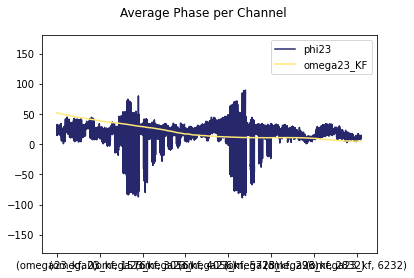

In [20]:
sdata.unstack(level=0)[['phi23']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#27286c', label='phi23', legend=True)
sdata.unstack(level=0)[['omega23_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', label='omega23_KF', legend=True)

C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:>], dtype=object)

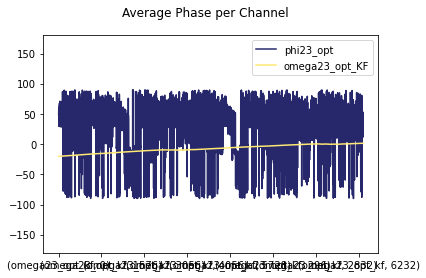

In [21]:
sdata.unstack(level=0)[['phi23_opt']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#27286c', label='phi23_opt', legend=True)
sdata.unstack(level=0)[['omega23_opt_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', label='omega23_opt_KF', legend=True)

In [22]:
print(np.average(sdata['phi23']), np.average(sdata['phi23_kf']), np.average(sdata['omega23_kf']),
    '\n ', np.average(sdata['phi23_opt']), np.average(sdata['phi23_opt_kf']), np.average(sdata['omega23_opt_kf']))


16.448798889914162 -0.0042854393849148156 20.413826316650912 
  26.080410824848695 -0.0012054249900254254 -7.468839564791493


C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:>], dtype=object)

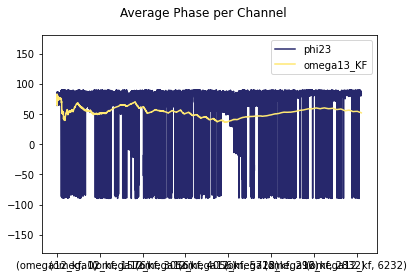

In [23]:
sdata.unstack(level=0)[['phi12']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#27286c', label='phi23', legend=True)
# sdata.unstack(level=0)[['phi12_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#4849ad', linestyle='dashed', label='phi23_KF', legend=True)
sdata.unstack(level=0)[['omega12_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', label='omega13_KF', legend=True)


C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:>], dtype=object)

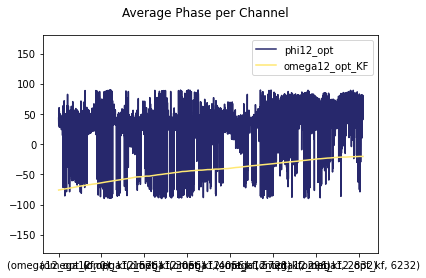

In [24]:
sdata.unstack(level=0)[['phi12_opt']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#27286c', label='phi12_opt', legend=True)
# sdata.unstack(level=0)[['phi12_opt_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#4849ad', linestyle='dashed', label='phi12_opt_KF', legend=True)
sdata.unstack(level=0)[['omega12_opt_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', label='omega12_opt_KF', legend=True)

In [25]:
print(np.average(sdata['phi12']), np.average(sdata['phi12_kf']), np.average(sdata['omega12_kf']), 
       '\n ', np.average(sdata['phi12_opt']), np.average(sdata['phi12_opt_kf']), np.average(sdata['omega12_opt_kf']))

55.24085644253681 -0.0028171090041678526 53.19764817084417 
  29.10302070909757 -0.004141504798467018 -43.36882305437076


C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:>], dtype=object)

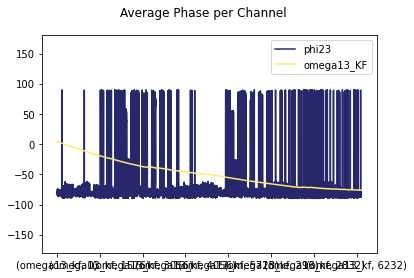

In [26]:
sdata.unstack(level=0)[['phi13']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#27286c', label='phi23', legend=True)
# sdata.unstack(level=0)[['phi13_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#4849ad', linestyle='dashed', label='phi23_KF', legend=True)
sdata.unstack(level=0)[['omega13_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', label='omega13_KF', legend=True)


C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:>], dtype=object)

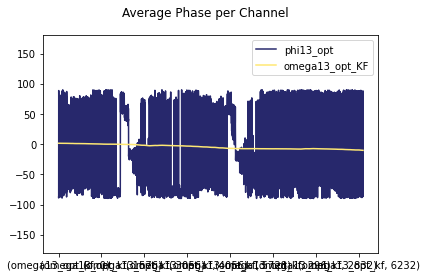

In [27]:
sdata.unstack(level=0)[['phi13_opt']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#27286c', label='phi13_opt', legend=True)
# sdata.unstack(level=0)[['phi13_opt_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#4849ad', linestyle='dashed', label='phi13_opt_KF', legend=True)
sdata.unstack(level=0)[['omega13_opt_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', label='omega13_opt_KF', legend=True)

In [28]:
print( np.average(sdata['phi13']), np.average(sdata['phi13_kf']), np.average(sdata['omega13_kf']),
      '\n ', np.average(sdata['phi13_opt']), np.average(sdata['phi13_opt_kf']), np.average(sdata['omega13_opt_kf']))

-63.00629061349499 -0.0071928827726604 -47.905410508144215 
  -13.0260279255132 -0.0007674835413327167 -4.4339185607801594


In [29]:
phi_channel = []
for i in range(0, len(data),96):
    phi_channel.append({"channel":data['channel'][i], 
                       "omega":data['omega'][i], 
                       "ave_phi12": np.average(sdata['phi12'][i:i+96]),
                       "ave_phi23": np.average(sdata['phi23'][i:i+96]), 
                       "ave_phi13": np.average(sdata['phi13'][i:i+96]),
                       "omega12": np.average(sdata['omega12_kf'][i:i+96]),
                       "omega23": np.average(sdata['omega23_kf'][i:i+96]),
                       "omega13": np.average(sdata['omega13_kf'][i:i+96]),
                       "ave_opt_phi12": np.average(sdata['phi12_opt'][i:i+96]),
                       "ave_opt_phi23": np.average(sdata['phi23_opt'][i:i+96]), 
                       "ave_opt_phi13": np.average(sdata['phi13_opt'][i:i+96]),
                       "omega12_opt": np.average(sdata['omega12_opt_kf'][i:i+96]),
                       "omega23_opt": np.average(sdata['omega23_opt_kf'][i:i+96]),
                       "omega13_opt": np.average(sdata['omega13_opt_kf'][i:i+96]),})
saverage_phi_perchannel = pd.DataFrame(phi_channel)
saverage_phi_perchannel

,channel,omega,ave_phi12,ave_phi23,ave_phi13,omega12,omega23,omega13,ave_opt_phi12,ave_opt_phi23,ave_opt_phi13,omega12_opt,omega23_opt,omega13_opt
0,33,2472.25,75.653014,23.536170,-80.810817,75.398085,51.064629,3.374636,38.777080,45.411556,-2.061364,-75.266059,-19.985142,1.479082
1,31,2468.25,49.969694,19.452901,-74.952405,52.165699,49.422611,0.829709,19.198673,26.579941,0.778614,-74.101764,-19.425962,1.401557
2,26,2458.25,62.459766,30.975733,-77.189501,51.781430,48.044566,-1.684239,26.939026,32.216291,-6.469683,-73.046954,-18.951789,1.290671
3,8,2420.25,54.389675,28.006999,-76.978326,55.021846,46.784545,-4.028133,22.432163,41.466873,-1.725964,-71.838320,-18.500126,1.145808
4,7,2418.25,52.323667,27.453771,-79.597561,62.829735,45.379000,-6.224993,22.417808,39.393740,-7.563452,-70.411528,-18.042547,1.018514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,17,2440.25,80.060912,14.917563,-71.896525,56.886399,5.801085,-74.908177,57.451674,30.187860,-7.985465,-21.336621,0.387892,-8.781263
70,35,2476.25,84.294992,13.455031,-69.124977,55.811906,5.392578,-75.190844,59.365698,29.816999,-12.067302,-21.054636,0.594747,-9.070585
71,16,2438.25,81.284458,12.959923,-80.130619,55.221025,5.233425,-75.448607,55.943379,26.750903,-27.930718,-20.751007,0.894592,-9.332356
72,34,2474.25,81.639331,9.054659,-63.056009,54.180797,5.062537,-75.819714,56.117052,29.888815,-9.619134,-20.483816,1.159216,-9.593237


array([<AxesSubplot:>], dtype=object)

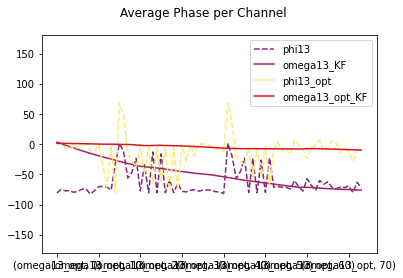

In [30]:
saverage_phi_perchannel.unstack(level=0)[['ave_phi13']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#812878', linestyle='dashed',  label='phi13', legend=True)
saverage_phi_perchannel.unstack(level=0)[['omega13']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#A22160', label='omega13_KF', legend=True)
saverage_phi_perchannel.unstack(level=0)[['ave_opt_phi13']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', linestyle='dashed',  label='phi13_opt', legend=True)
saverage_phi_perchannel.unstack(level=0)[['omega13_opt']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#d31717', label='omega13_opt_KF', legend=True)


array([<AxesSubplot:>], dtype=object)

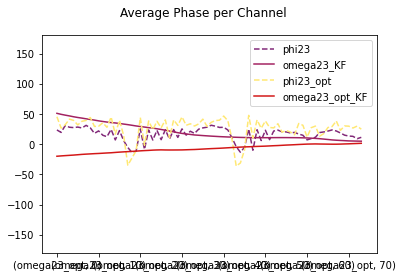

In [31]:
saverage_phi_perchannel.unstack(level=0)[['ave_phi23']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#812878', linestyle='dashed',  label='phi23', legend=True)
saverage_phi_perchannel.unstack(level=0)[['omega23']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#A22160', label='omega23_KF', legend=True)
saverage_phi_perchannel.unstack(level=0)[['ave_opt_phi23']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', linestyle='dashed',  label='phi23_opt', legend=True)
saverage_phi_perchannel.unstack(level=0)[['omega23_opt']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#d31717', label='omega23_opt_KF', legend=True)


array([<AxesSubplot:>], dtype=object)

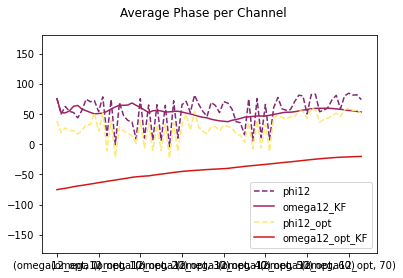

In [32]:
saverage_phi_perchannel.unstack(level=0)[['ave_phi12']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#812878', linestyle='dashed',  label='phi12', legend=True)
saverage_phi_perchannel.unstack(level=0)[['omega12']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#A22160', label='omega12_KF', legend=True)
saverage_phi_perchannel.unstack(level=0)[['ave_opt_phi12']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', linestyle='dashed',  label='phi12_opt', legend=True)
saverage_phi_perchannel.unstack(level=0)[['omega12_opt']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#d31717', label='omega12_opt_KF', legend=True)


In [33]:
saverage_phi_perchannel

,channel,omega,ave_phi12,ave_phi23,ave_phi13,omega12,omega23,omega13,ave_opt_phi12,ave_opt_phi23,ave_opt_phi13,omega12_opt,omega23_opt,omega13_opt
0,33,2472.25,75.653014,23.536170,-80.810817,75.398085,51.064629,3.374636,38.777080,45.411556,-2.061364,-75.266059,-19.985142,1.479082
1,31,2468.25,49.969694,19.452901,-74.952405,52.165699,49.422611,0.829709,19.198673,26.579941,0.778614,-74.101764,-19.425962,1.401557
2,26,2458.25,62.459766,30.975733,-77.189501,51.781430,48.044566,-1.684239,26.939026,32.216291,-6.469683,-73.046954,-18.951789,1.290671
3,8,2420.25,54.389675,28.006999,-76.978326,55.021846,46.784545,-4.028133,22.432163,41.466873,-1.725964,-71.838320,-18.500126,1.145808
4,7,2418.25,52.323667,27.453771,-79.597561,62.829735,45.379000,-6.224993,22.417808,39.393740,-7.563452,-70.411528,-18.042547,1.018514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,17,2440.25,80.060912,14.917563,-71.896525,56.886399,5.801085,-74.908177,57.451674,30.187860,-7.985465,-21.336621,0.387892,-8.781263
70,35,2476.25,84.294992,13.455031,-69.124977,55.811906,5.392578,-75.190844,59.365698,29.816999,-12.067302,-21.054636,0.594747,-9.070585
71,16,2438.25,81.284458,12.959923,-80.130619,55.221025,5.233425,-75.448607,55.943379,26.750903,-27.930718,-20.751007,0.894592,-9.332356
72,34,2474.25,81.639331,9.054659,-63.056009,54.180797,5.062537,-75.819714,56.117052,29.888815,-9.619134,-20.483816,1.159216,-9.593237


In [34]:
saverage_phi_perchannel['omega12_kf'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['omega12'])
saverage_phi_perchannel['omega23_kf'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['omega23'])
saverage_phi_perchannel['omega13_kf'] = ((2.9*1e10)/(2*3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['omega13'])
saverage_phi_perchannel['theta12'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['ave_phi12']) # c/f * xx * 1/2pi * 1/d
saverage_phi_perchannel['theta23'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['ave_phi23'])
saverage_phi_perchannel['theta13'] = ((2.9*1e10)/(2*3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['ave_phi13'])
saverage_phi_perchannel['omega12_opt_kf'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['omega12_opt']) # c/f * xx * 1/2pi * 1/d
saverage_phi_perchannel['omega23_opt_kf'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['omega23_opt'])
saverage_phi_perchannel['omega13_opt_kf'] = ((2.9*1e10)/(2*3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['omega13_opt'])
saverage_phi_perchannel['theta12_opt'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['ave_opt_phi12']) # c/f * xx * 1/2pi * 1/d
saverage_phi_perchannel['theta23_opt'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['ave_opt_phi23'])
saverage_phi_perchannel['theta13_opt'] = ((2.9*1e10)/(2*3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['ave_opt_phi13'])

In [40]:
print('\n theta (12, 23, 13)', np.average(saverage_phi_perchannel['theta12']), np.average(saverage_phi_perchannel['theta23']), np.average(saverage_phi_perchannel['theta13']),
      '\n theta_KF', np.average(saverage_phi_perchannel['omega12_kf']), np.average(saverage_phi_perchannel['omega23_kf']), np.average(saverage_phi_perchannel['omega13_kf']),
      '\n theta_optimized', np.average(saverage_phi_perchannel['theta12_opt']), np.average(saverage_phi_perchannel['theta23_opt']), np.average(saverage_phi_perchannel['theta13_opt']),
      '\n omega_optimized', np.average(saverage_phi_perchannel['omega12_opt_kf']), np.average(saverage_phi_perchannel['omega23_opt_kf']), np.average(saverage_phi_perchannel['omega13_opt_kf']))


 theta (12, 23, 13) 29.8158820344641 8.879952658156277 -17.014881515953626 
 theta_KF 28.738548575239097 11.025594584942581 -12.94090062636097 
 theta_optimized 15.705085834598675 14.075461105100228 -3.5289609527797814 
 omega_optimized -23.42131611432619 -4.032101393382534 -1.1974291837945883


array([<AxesSubplot:>], dtype=object)

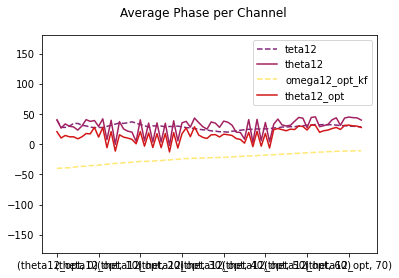

In [36]:
saverage_phi_perchannel.unstack(level=0)[['omega12_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#812878', linestyle='dashed',  label='teta12', legend=True)
saverage_phi_perchannel.unstack(level=0)[['theta12']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#A22160', label='theta12', legend=True)
saverage_phi_perchannel.unstack(level=0)[['omega12_opt_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', linestyle='dashed',  label='omega12_opt_kf', legend=True)
saverage_phi_perchannel.unstack(level=0)[['theta12_opt']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#d31717', label='theta12_opt', legend=True)


array([<AxesSubplot:>], dtype=object)

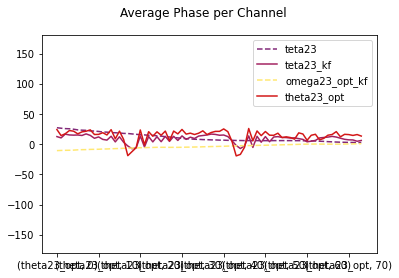

In [37]:
saverage_phi_perchannel.unstack(level=0)[['omega23_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#812878', linestyle='dashed',  label='teta23', legend=True)
saverage_phi_perchannel.unstack(level=0)[['theta23']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#A22160', label='teta23_kf', legend=True)
saverage_phi_perchannel.unstack(level=0)[['omega23_opt_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', linestyle='dashed',  label='omega23_opt_kf', legend=True)
saverage_phi_perchannel.unstack(level=0)[['theta23_opt']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#d31717', label='theta23_opt', legend=True)


array([<AxesSubplot:>], dtype=object)

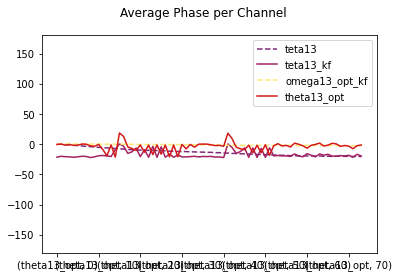

In [38]:
saverage_phi_perchannel.unstack(level=0)[['omega13_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#812878', linestyle='dashed',  label='teta13', legend=True)
saverage_phi_perchannel.unstack(level=0)[['theta13']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#A22160', label='teta13_kf', legend=True)
saverage_phi_perchannel.unstack(level=0)[['omega13_opt_kf']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#FFE873', linestyle='dashed',  label='omega13_opt_kf', legend=True)
saverage_phi_perchannel.unstack(level=0)[['theta13_opt']].plot(subplots=True, title="Average Phase per Channel", ylim=[-180,+180], color= '#d31717', label='theta13_opt', legend=True)
